# Generating the Models Used in the Binary Classification Example

----
# Overview and Setup

This is an example of how someone might generate and store models that can be compared for fairness. 

## Notebook Contents

[Part 1](#part1) - Data and Analysis

[Part 2](#part2) - Length of Stay Models (Baseline)

&nbsp;&nbsp;&nbsp;&nbsp;[Part 2.1](#part2.1) - From-The-Box Models

&nbsp;&nbsp;&nbsp;&nbsp;[Part 2.2](#part2.2) - AIF360 Fairness-Aware  (In-Process) Models

&nbsp;&nbsp;&nbsp;&nbsp;[Part 2.3](#part2.3) - FairLearn Fairness-Aware  (In-Process) Models

&nbsp;&nbsp;&nbsp;&nbsp;[Part 2.4](#part2.4) - Other Methods

[Part 3](#part3) - Comparing Models
    Includes the fairMLHealth model comparison tool, as well as an example of the FairLearn Dashboard.

[Part 4](#part4) - Save Results

In [54]:
from IPython.display import Markdown
from fairMLHealth.utils import helpers, model_comparison
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, equalized_odds_difference, equalized_odds_ratio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
import datetime

def check_timer(start_time=None):
    if start_time is not None:
        elapsed_time = datetime.datetime.now() - start_time
        rprt = f"{elapsed_time} (hr:mn:sc)"
        return rprt
        return elapsed_time
    else:
        return datetime.datetime.now()

start_time = check_timer()
check_timer(start_time)

'0:00:00.000028 (hr:mn:sc)'

In [3]:
import warnings
#warnings.filterwarnings('ignore', module='numpy' )
warnings.filterwarnings('ignore', module='tensorflow' )

----
# Part 1 - Data and Analysis <a class="anchor" id="part1"></a>


## Loading MIMIC III Data

This example uses a data subset from the [MIMIC-III clinical database](https://mimic.physionet.org/gettingstarted/access/) to predict "length of stay" (LOS) value. For this example, LOS is total ICU time for a given hospital admission in patients 65 and above. The raw LOS value is then converted to a binary value specifying whether an admission's length of stay is greater than the sample mean. A baseline model is then generated using the Scikit-Learn RandomForestClassifier.

Note that the code below will automatically unzip and format all necessary data for these experiments from a raw download of MIMIC-III data (saving the formatted data in the same MIMIC folder). MIMIC-III is a freely available database, however all users must pass a quick human subjects certification course. If you would like to run this example on your own, [follow these steps to be granted access to MIMIC III](https://mimic.physionet.org/gettingstarted/access/) and download the data.

In [4]:
# path_to_mimic_data_folder = "[path to your downloaded data folder]"
path_to_mimic_data_folder = "~/data/MIMIC"

In [5]:
# output file for combined data and models
output_file = os.path.expanduser("~/data/fairness_and_bias/mimic_model_comparison/binary_classification.joblib")


## Data Subset <a id="datasubset"></a>
Example models in this notebook use data from all years of the MIMIC-III dataset for patients aged 65 and older. Data are imported at the encounter level with all additional patient identification dropped. All models include an "AGE" feature, simplified to 5-year bins, as well as boolean diagnosis and procedure features categorized through the Clinical Classifications Software system ([HCUP](https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp)). All features other than age are one-hot encoded and prefixed with their variable type (e.g. "GENDER_", "ETHNICITY_").  

In [6]:
df = helpers.load_mimic3_example(path_to_mimic_data_folder) 
df.drop('GENDER_F', axis=1, inplace=True)
df = df.loc[df['AGE'].ge(65),:]
helpers.print_feature_table(df)
display(Markdown('---'))
display(df.head())


 This data subset has 22434 total observations and 648 input features 



,Raw Feature,Category Count (Encoded Features)
0,AGE,1
1,DIAGNOSIS,282
2,ETHNICITY,41
3,GENDER,1
4,INSURANCE,5
5,LANGUAGE,69
6,MARRIED,7
7,PROCEDURE,222
8,RELIGION,20


---

,ADMIT_ID,AGE,GENDER_M,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETHNICITY_ASIAN,ETHNICITY_ASIAN - ASIAN INDIAN,ETHNICITY_ASIAN - CAMBODIAN,ETHNICITY_ASIAN - CHINESE,ETHNICITY_ASIAN - FILIPINO,...,PROCEDURE_CCS_222,PROCEDURE_CCS_223,PROCEDURE_CCS_224,PROCEDURE_CCS_225,PROCEDURE_CCS_226,PROCEDURE_CCS_227,PROCEDURE_CCS_228,PROCEDURE_CCS_229,PROCEDURE_CCS_231,length_of_stay
0,843270,65.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.144444
1,830178,70.0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,5.496528
2,802276,75.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.768056
5,875616,70.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,6.988889
7,840524,75.0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,5.364583


,count,mean,std,min,25%,50%,75%,max
length_of_stay,22434.000000,9.115200,6.208700,0.004200,4.735200,7.579900,12.017700,29.988900
long_los,22434.000000,0.388000,0.487300,0.000000,0.000000,0.000000,1.000000,1.000000


---

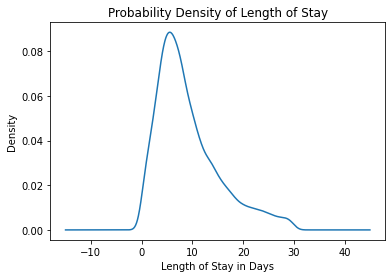

In [7]:
# Generate a binary target flagging whether an observation's length_of_stay value is above or below the mean. 
mean_val=df['length_of_stay'].mean()
df['long_los'] = df['length_of_stay'].apply(lambda x: 1 if x > mean_val else 0)
los_tbl = df[['length_of_stay', 'long_los']].describe().transpose().round(4)
display(los_tbl.style.applymap(helpers.highlight_col, subset=pd.IndexSlice[:, 'mean']))

# Display LOS distributions
display(Markdown('---'))
ax = df['length_of_stay'].plot(kind='kde', title="Probability Density of Length of Stay")
ax.set_xlabel("Length of Stay in Days")
plt.show()

----
# Part 2 - Length of Stay Models <a class="anchor" id="part2"></a>

In [ ]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as sk_metric

### Baseline - Random Sampling

In [9]:
import random

# generate "predictions" as random sample of target values
y_test = df['long_los']
pos_weight = y_test.mean()
weights = [1-pos_weight, pos_weight]
values = list(set(y_test))
y_pred_baseline = np.array(random.choices(values, weights, k=df.shape[0]))
y_prob_baseline = y_pred_baseline

# display baseline performance 
print("\n", "Prediction Scores for Random Sampling:", "\n", 
      sk_metric.classification_report(y_test, y_pred_baseline, target_names=['LOS > mean', 'LOS <= mean']))


 Prediction Scores for Random Sampling: 
               precision    recall  f1-score   support

  LOS > mean       0.61      0.62      0.62     13730
 LOS <= mean       0.39      0.39      0.39      8704

    accuracy                           0.53     22434
   macro avg       0.50      0.50      0.50     22434
weighted avg       0.53      0.53      0.53     22434



### Split Data for other Models

In [10]:
# Subset and Split Data
X = df.loc[:,[c for c in df.columns if c not in ['ADMIT_ID','length_of_stay', 'long_los']]]
y = df.loc[:, ['long_los']]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)



----
# Part 2.1 - From-The-Box Models <a class="anchor" id="part2.1"></a>

### Naive Bayes Classifier

In [138]:
from sklearn.naive_bayes import BernoulliNB

# Set model parameters (currently set as default values, but defined here to be explicit)
nb_params = {'alpha':20, 'fit_prior':True}

# Train Model
start_time = check_timer()
nb_model = BernoulliNB(**nb_params)
nb_model.fit(X_train, y_train.iloc[:,0])
y_pred_nb = nb_model.predict(X_test)
print("Model finished in", check_timer(start_time))

# display performance 
print("\n", "Naive Bayes Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_nb, target_names=['LOS <= mean', 'LOS > mean']))

Model finished in 0:00:00.196712 (hr:mn:sc)

 Naive Bayes Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.76      0.85      0.80      4531
  LOS > mean       0.71      0.58      0.64      2873

    accuracy                           0.75      7404
   macro avg       0.74      0.72      0.72      7404
weighted avg       0.74      0.75      0.74      7404



### Decision Tree Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [129]:
# Set model parameters (currently set as default values, but defined here to be explicit)
dt_params = {'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'criterion': 'entropy'}

# Train Model
start_time = check_timer()
dt_model = DecisionTreeClassifier(**dt_params)
dt_model.fit(X_train, y_train.iloc[:,0])
y_pred_dt = dt_model.predict(X_test)
print("Model finished in", check_timer(start_time))

# display performance 
print("\n", "Decision Tree Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_dt, target_names=['LOS <= mean', 'LOS > mean']) )

Model finished in 0:00:00.533237 (hr:mn:sc)

 Decision Tree Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.74      0.85      0.79      4531
  LOS > mean       0.69      0.52      0.59      2873

    accuracy                           0.72      7404
   macro avg       0.71      0.69      0.69      7404
weighted avg       0.72      0.72      0.71      7404



### Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [124]:
# Set model parameters (currently set as default values, but defined here to be explicit)
rf_params = {'criterion':'entropy', 'n_estimators': 1800, 'min_samples_split': 5, 'bootstrap': False}

# Train Model
start_time = check_timer()
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train, y_train.iloc[:,0])
y_pred_rf = rf_model.predict(X_test)
print("Model finished in", check_timer(start_time))

# display performance 
print("\n", "Random Forest Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_rf, target_names=['LOS <= mean', 'LOS > mean']) )

Model finished in 0:02:38.296874 (hr:mn:sc)

 Random Forest Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.77      0.90      0.83      4531
  LOS > mean       0.78      0.57      0.66      2873

    accuracy                           0.77      7404
   macro avg       0.77      0.74      0.74      7404
weighted avg       0.77      0.77      0.76      7404



### Logit Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

In [14]:
lr_params = {'penalty':"none", 'max_iter':10**4}

# Train Model
start_time = check_timer()
lr_model = LogisticRegression(**lr_params)
lr_model.fit(X_train, y_train.iloc[:,0])
y_pred_lr = lr_model.predict(X_test)
print("Model finished in", check_timer(start_time))

# display performance 
print("\n", "Logit Regression Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_lr, zero_division=0, target_names=['LOS <= mean', 'LOS > mean']) )

Model finished in 0:00:09.587844 (hr:mn:sc)

 Logit Regression Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.79      0.88      0.83      4531
  LOS > mean       0.76      0.63      0.69      2873

    accuracy                           0.78      7404
   macro avg       0.77      0.75      0.76      7404
weighted avg       0.78      0.78      0.77      7404



### SVM Model

In [150]:
from sklearn.svm import LinearSVC 
import warnings
warnings.filterwarnings('ignore', message="Liblinear failed to converge, increase the number of iterations.")

svm_params = {'max_iter':10**4}

# Train Model
start_time = check_timer()
svm_model = LinearSVC(**svm_params)
svm_model.fit(X_train, y_train.iloc[:,0])
y_pred_svm = svm_model.predict(X_test)
print("Model finished in", check_timer(start_time))

# display performance 
print("\n", "SVM Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_svm, target_names=['LOS <= mean', 'LOS > mean'], zero_division=0) )

Model finished in 0:00:23.015004 (hr:mn:sc)

 SVM Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.75      0.94      0.83      4531
  LOS > mean       0.83      0.51      0.63      2873

    accuracy                           0.77      7404
   macro avg       0.79      0.72      0.73      7404
weighted avg       0.78      0.77      0.75      7404



## LightGBM

In [56]:
import lightgbm as lgb
lgb_params = {'objective':'binary', 'metric':'auc', 'learning_rate':0.03,
              'num_leaves':10, 'max_depth':3}

start_time = check_timer()
lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(X_train, y_train.iloc[:,0])
y_pred_lgb = lgb_model.predict(X_test)
print("Model finished in", check_timer(start_time))

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_lgb, target_names=['LOS <= mean', 'LOS > mean']) )


Model finished in 0:00:00.522620 (hr:mn:sc)

 Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.73      0.91      0.81      4531
  LOS > mean       0.76      0.47      0.58      2873

    accuracy                           0.74      7404
   macro avg       0.74      0.69      0.69      7404
weighted avg       0.74      0.74      0.72      7404



## XGBOOST Model

In [57]:
from xgboost import XGBClassifier

# Set model parameters
xgb_params = {'colsample_bytree': 1.0, 'gamma': 2, 'learning_rate': 0.05, 'max_depth': 5, 
                'min_child_weight': 1,  'n_estimators': 600, 'subsample': 0.6}

# Train Model
xgb_model = XGBClassifier(**xgb_params)
start_time = check_timer()
xgb_model.fit(X_train, y_train.iloc[:,0])
y_pred_xgb = xgb_model.predict(X_test)
print("Model finished in", check_timer(start_time))

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_xgb, target_names=['LOS <= mean', 'LOS > mean']) )


Model finished in 0:02:05.872574 (hr:mn:sc)

 Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.79      0.88      0.83      4531
  LOS > mean       0.77      0.63      0.70      2873

    accuracy                           0.78      7404
   macro avg       0.78      0.76      0.76      7404
weighted avg       0.78      0.78      0.78      7404



----
# Part 2.2 - AIF360 Fairness-Aware  (In-Process) Models <a class="anchor" id="part2.2"></a>

### Data Preparation

In [18]:
test_data = pd.concat([X_test, y_test], axis=1)
train_data = pd.concat([X_train, y_train], axis=1)
df = pd.concat([test_data, train_data], ignore_index=True)
df.head()


,AGE,GENDER_M,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETHNICITY_ASIAN,ETHNICITY_ASIAN - ASIAN INDIAN,ETHNICITY_ASIAN - CAMBODIAN,ETHNICITY_ASIAN - CHINESE,ETHNICITY_ASIAN - FILIPINO,ETHNICITY_ASIAN - JAPANESE,...,PROCEDURE_CCS_222,PROCEDURE_CCS_223,PROCEDURE_CCS_224,PROCEDURE_CCS_225,PROCEDURE_CCS_226,PROCEDURE_CCS_227,PROCEDURE_CCS_228,PROCEDURE_CCS_229,PROCEDURE_CCS_231,long_los
0,80.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,80.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,80.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,65.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,75.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [19]:
import aif360.datasets as aifdata

aif_data = pd.concat([X, y], axis=1)
los_dataset = aifdata.StandardDataset(df=aif_data, 
                        label_name='long_los',
                        favorable_classes=[1],
                        instance_weights_name=None,
                        categorical_features=['AGE'],
                        protected_attribute_names=['LANGUAGE_ENGL'],       
                        privileged_classes=[[1]],                   
                        custom_preprocessing=None)

In [20]:
from collections import defaultdict
from aif360.metrics import ClassificationMetric

def test_thresholds(dataset, model, thresh_arr=np.linspace(0.01, 0.5, 50)):
    ''' from AIF360 tutorial, used throughout the tutorial to find best 
            threshold using a validation set
    '''
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    #
    sens_ind = 0
    sens_attr = dataset.protected_attribute_names[sens_ind]
    unprivileged_groups = [{sens_attr: v} for v in
                       dataset.unprivileged_protected_attributes[sens_ind]]
    privileged_groups = [{sens_attr: v} for v in
                     dataset.privileged_protected_attributes[sens_ind]]
    #
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs


def aif_dataset_measures(dataset, models):
    ''' alterned version of test_thresholds from AIF360 tutorial
    '''
    if not isinstance(models, (list, dict)):
        models = [models]
    if not isinstance(models, dict):
        models = {f'model_{i}':m for i,m in enumerate(models)}
    
    #
    sens_ind = 0
    sens_attr = dataset.protected_attribute_names[sens_ind]
    unprivileged_groups = [{sens_attr: v} for v in
                       dataset.unprivileged_protected_attributes[sens_ind]]
    privileged_groups = [{sens_attr: v} for v in
                     dataset.privileged_protected_attributes[sens_ind]]
    #
    metric_dict = defaultdict(list)
    for name,model in models.items():
        y_pred = model.predict(dataset).labels
        dataset_pred = dataset.copy()
        dataset_pred.labels = y_pred
        metric = ClassificationMetric(
                    dataset, dataset_pred,
                    unprivileged_groups=unprivileged_groups,
                    privileged_groups=privileged_groups)
        
        metric_dict['Disparate Impact Ratio'].append(metric.disparate_impact())
        metric_dict['Statistical Parity Difference'].append(metric.statistical_parity_difference())
        metric_dict['Average Odds Difference'].append(metric.average_odds_difference())
        metric_dict['Equal Opportunity Difference'].append(metric.equal_opportunity_difference())
        metric_dict['Balanced Accuracy Difference'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_dict['Between-Group Coefficient of Variation'].append(metric.between_group_coefficient_of_variation())
        metric_dict['Theil Index'].append(metric.theil_index())
    
    results = pd.DataFrame().from_dict(metric_dict).transpose()
    results.columns = models.keys()
    return(results)

/Users/christineallen/anaconda3/envs/fairMLHealth/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/christineallen/anaconda3/envs/fairMLHealth/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/christineallen/anaconda3/envs/fairMLHealth/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint

### GerryFair Classifier

In [21]:
from aif360.algorithms.inprocessing import GerryFairClassifier

C = 100
print_flag = True
gamma = .005


aif_gf_model = GerryFairClassifier(fairness_def='FN', #fairness_def: Fairness notion, FP, FN
                                   C=C, 
                                   printflag=print_flag, 
                                   gamma=gamma, 
                                   max_iters=500, 
                                   heatmapflag=False)

start_time = check_timer()
aif_gf_model.fit(los_dataset, early_termination=True)
yhat_aifgf = aif_gf_model.predict(los_dataset, threshold=False)
print("Model finished in", check_timer(start_time))

print("\n",
      "Note: Theoretically a predictor can be set, but no valid argument could be found during testing.",
      "Per the documentation: \"predictor: Hypothesis class for the Learner. Supports LR, SVM, KR, Trees\"")

iteration: 1, error: 0.20986003387715074, fairness violation: 0.0036408985147281703, violated group size: 0.1964428991709013
iteration: 2, error: 0.20986003387715074, fairness violation: 0.0036408985147281703, violated group size: 0.1964428991709013
iteration: 3, error: 0.20986003387715074, fairness violation: 0.0036408985147281703, violated group size: 0.1964428991709013
iteration: 4, error: 0.20986003387715074, fairness violation: 0.0036408985147281703, violated group size: 0.1964428991709013
iteration: 5, error: 0.20986003387715074, fairness violation: 0.0036408985147281703, violated group size: 0.1964428991709013
Model finished in 0:00:12.300074 (hr:mn:sc)

 Note: Theoretically a predictor can be set, but no valid argument could be found during testing. Per the documentation: "predictor: Hypothesis class for the Learner. Supports LR, SVM, KR, Trees"


### Prejudice Remover Regularizer

In [22]:
from aif360.algorithms.inprocessing import prejudice_remover
aif_prr_model = prejudice_remover.PrejudiceRemover(sensitive_attr='LANGUAGE_ENGL')
start_time = check_timer()
aif_prr_model.fit(los_dataset)
yhat_aif_prr = aif_prr_model.predict(los_dataset)
print("Model finished in", check_timer(start_time))

Model finished in 0:01:31.190817 (hr:mn:sc)


### Adversarial Debiasing

In [23]:
from aif360.algorithms.inprocessing import adversarial_debiasing
import tensorflow as tf

sess = tf.compat.v1.Session()

aif_adb_model = adversarial_debiasing.AdversarialDebiasing(privileged_groups = [{'LANGUAGE_ENGL': 1}], 
                                                           unprivileged_groups = [{'LANGUAGE_ENGL': 0}],
                                                             scope_name='plain_classifier',
                                                          debias=False,
                                                          sess=sess)
start_time = check_timer()
aif_adb_model.fit(los_dataset)
yhat_aifadb = aif_adb_model.predict(los_dataset)
print("Model finished in", check_timer(start_time))
 




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




epoch 0; iter: 0; batch classifier loss: 0.734759
epoch 1; iter: 0; batch classifier loss: 0.439836
epoch 2; iter: 0; batch classifier loss: 0.426588
epoch 3; iter: 0; batch classifier loss: 0.511115
epoch 4; iter: 0; batch classifier loss: 0.426629
epoch 5; iter: 0; batch classifier loss: 0.382949
epoch 6; iter: 0; batch classifier loss: 0.395555
epoch 7; iter: 0; batch classifier loss: 0.346854
epoch 8; iter: 0; ba

### Other AIF360 Fairness-Aware Options that are Not Yet Working

In [24]:
from aif360.algorithms.inprocessing import meta_fair_classifier
aif_mfc_model = meta_fair_classifier.MetaFairClassifier(sensitive_attr='LANGUAGE_ENGL')
#aif_mfc_model.fit(los_dataset)
#yhat_aifmfc = aif_mfc_model.predict(los_dataset)
print("meta_fair_classifier failed to converge in testing")

meta_fair_classifier failed to converge in testing


----
# Part 2.3 - FairLearn Fairness-Aware  (In-Process) Models <a class="anchor" id="part2.3"></a>

In [25]:
from fairlearn.reductions import GridSearch, ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds, DemographicParity 

### Grid Search with LGBM

In [58]:
# Train GridSearch
gs_lgb_model = GridSearch(lgb.LGBMClassifier(**lgb_params),
                           constraints=EqualizedOdds(),
                           grid_size=50)

start_time = check_timer()
gs_lgb_model.fit(X_train, y_train, sensitive_features=X_train['LANGUAGE_ENGL'])
y_pred_gs_lgb = gs_lgb_model.predict(X_test)
print("Model finished in", check_timer(start_time))

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_gs_lgb, target_names=['LOS <= mean', 'LOS > mean']) )


Model finished in 0:01:06.075871 (hr:mn:sc)

 Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.73      0.91      0.81      4531
  LOS > mean       0.76      0.47      0.58      2873

    accuracy                           0.74      7404
   macro avg       0.74      0.69      0.69      7404
weighted avg       0.74      0.74      0.72      7404



### Grid Search  with XGBOOST

In [27]:
# Train GridSearch
gs_xgb_model = GridSearch(XGBClassifier(**xgb_params),
                   constraints=EqualizedOdds(),
                   grid_size=50)

start_time = check_timer()
gs_xgb_model.fit(X_train, y_train, sensitive_features=X_train['LANGUAGE_ENGL'])
y_pred_gs_xgb = gs_xgb_model.predict(X_test)
print("Model finished in", check_timer(start_time))

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_gs_xgb, target_names=['LOS <= mean', 'LOS > mean']) )

Model finished in 1:22:50.390551 (hr:mn:sc)

 Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.79      0.88      0.83      4531
  LOS > mean       0.77      0.63      0.70      2873

    accuracy                           0.78      7404
   macro avg       0.78      0.76      0.76      7404
weighted avg       0.78      0.78      0.78      7404



### Grid Search on Random Forest

In [103]:
# Train GridSearch
gs_rfEO_model = GridSearch(RandomForestClassifier(**rf_params),
                   constraints=EqualizedOdds(),
                   grid_size=50)

start_time = check_timer()
gs_rfEO_model.fit(X_train, y_train, sensitive_features=X_train['LANGUAGE_ENGL'])
y_pred_gs_rfEO = gs_rfEO_model.predict(X_test)
print("Model finished in", check_timer(start_time))

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_gs_rfEO, target_names=['LOS <= mean', 'LOS > mean']) )


Model finished in 0:04:47.611597 (hr:mn:sc)

 Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.75      0.91      0.82      4531
  LOS > mean       0.79      0.53      0.63      2873

    accuracy                           0.76      7404
   macro avg       0.77      0.72      0.73      7404
weighted avg       0.77      0.76      0.75      7404



In [106]:
# Train GridSearch
gs_rfDP_model = GridSearch(RandomForestClassifier(**rf_params),
                           constraints=DemographicParity(),
                           grid_size=50)

start_time = check_timer()
gs_rfDP_model.fit(X_train, y_train, sensitive_features=X_train['LANGUAGE_ENGL'])
y_pred_gs_rfDP = gs_rfDP_model.predict(X_test)
print("Model finished in", check_timer(start_time))

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_gs_rfDP, target_names=['LOS <= mean', 'LOS > mean']) )


Model finished in 0:05:11.359366 (hr:mn:sc)

 Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.74      0.92      0.82      4531
  LOS > mean       0.79      0.49      0.60      2873

    accuracy                           0.75      7404
   macro avg       0.76      0.70      0.71      7404
weighted avg       0.76      0.75      0.73      7404



### Exponentiated Gradient

In progress...

In [61]:
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient
eg_lgb_model = ExponentiatedGradient(lgb.LGBMClassifier(**lgb_params), 
                                     constraints=DemographicParity())
eg_lgb_model.fit(X_train, y_train, sensitive_features=X_train['LANGUAGE_ENGL'])
y_pred_eg_lgb = eg_lgb_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_eg_lgb, target_names=['LOS <= mean', 'LOS > mean']) )



 Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.73      0.90      0.81      4531
  LOS > mean       0.76      0.47      0.58      2873

    accuracy                           0.74      7404
   macro avg       0.74      0.69      0.69      7404
weighted avg       0.74      0.74      0.72      7404



In [62]:
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient
eg_rf_model = ExponentiatedGradient(RandomForestClassifier(**rf_params), 
                                    constraints=DemographicParity())  #NOTE: this may alter the model; TODO: test to determine if this is true
eg_rf_model.fit(X_train, y_train, sensitive_features=X_train['LANGUAGE_ENGL'])
y_pred_eg_rf = eg_rf_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_eg_rf, target_names=['LOS <= mean', 'LOS > mean']) )



 Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.75      0.91      0.82      4531
  LOS > mean       0.78      0.51      0.62      2873

    accuracy                           0.75      7404
   macro avg       0.76      0.71      0.72      7404
weighted avg       0.76      0.75      0.74      7404



----
# Part 2.4 - Other Methods <a class="anchor" id="part2.4"></a>

## Empirical Risk Minimization (Fair_ERM)

In [32]:
class Linear_FERM:
    """ Fairness-Aware Classifier from https://github.com/jmikko/fair_ERM/blob/master/linear_ferm.py
    """
    # The linear FERM algorithm
    def __init__(self, dataset, model, sensible_feature):
        self.dataset = dataset
        self.values_of_sensible_feature = list(set(sensible_feature))
        self.list_of_sensible_feature_train = sensible_feature
        self.val0 = np.min(self.values_of_sensible_feature)
        self.val1 = np.max(self.values_of_sensible_feature)
        self.model = model
        self.u = None
        self.max_i = None

    def new_representation(self, examples):
        if self.u is None:
            sys.exit('Model not trained yet!')
            return 0

        new_examples = np.array([ex - self.u * (ex[self.max_i] / self.u[self.max_i]) for ex in examples])
        new_examples = np.delete(new_examples, self.max_i, 1)
        return new_examples

    def predict(self, examples):
        new_examples = self.new_representation(examples)
        prediction = self.model.predict(new_examples)
        return prediction

    def fit(self):
        # Evaluation of the empirical averages among the groups
        tmp = [ex for idx, ex in enumerate(self.dataset.data)
               if self.dataset.target[idx] == 1 and self.list_of_sensible_feature_train[idx] == self.val1]
        average_A_1 = np.mean(tmp, 0)
        tmp = [ex for idx, ex in enumerate(self.dataset.data)
               if self.dataset.target[idx] == 1 and self.list_of_sensible_feature_train[idx] == self.val0]
        average_not_A_1 = np.mean(tmp, 0)

        # Evaluation of the vector u (difference among the two averages)
        self.u = -(average_A_1 - average_not_A_1)
        self.max_i = np.argmax(self.u)

        # Application of the new representation
        newdata = np.array([ex - self.u * (ex[self.max_i] / self.u[self.max_i]) for ex in self.dataset.data])
        newdata = np.delete(newdata, self.max_i, 1)
        self.dataset = namedtuple('_', 'data, target')(newdata, self.dataset.target)

        # Fitting the linear model by using the new data
        if self.model:
            self.model.fit(self.dataset.data, self.dataset.target)

In [111]:
from collections import namedtuple
import copy


train_dataset = namedtuple('_', 'data, target')(X_train.to_numpy(), y_train.to_numpy())
test_dataset = namedtuple('_', 'data, target')(X_test.to_numpy(), y_test.to_numpy())

# predictor must be trained (or otherwise have attribute 'estimators_'); predictor may be altered by the fit process (TODO: check this)
lr_predictor = copy.deepcopy(lr_model)
ermL_lr_model = Linear_FERM(train_dataset, lr_predictor, X_train['LANGUAGE_ENGL'].to_numpy())  
ermL_lr_model.fit()
y_pred_ermL_lr = ermL_lr_model.predict(test_dataset.data)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_ermL_lr, target_names=['LOS <= mean', 'LOS > mean']) )



 Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.79      0.88      0.83      4531
  LOS > mean       0.76      0.63      0.69      2873

    accuracy                           0.78      7404
   macro avg       0.77      0.75      0.76      7404
weighted avg       0.78      0.78      0.77      7404



In [113]:

# predictor must be trained (or otherwise have attribute 'estimators_'); predictor may be altered by the fit process (TODO: check this)
svm_predictor = copy.deepcopy(svm_model)
ermL_svm_model = Linear_FERM(train_dataset, svm_predictor, X_train['LANGUAGE_ENGL'].to_numpy())  
ermL_svm_model.fit()
y_pred_ermL_svm = ermL_svm_model.predict(test_dataset.data)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_ermL_svm, target_names=['LOS <= mean', 'LOS > mean']) )


 Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.78      0.89      0.83      4531
  LOS > mean       0.77      0.61      0.68      2873

    accuracy                           0.78      7404
   macro avg       0.78      0.75      0.75      7404
weighted avg       0.78      0.78      0.77      7404



In [117]:
from load_data import load_adult
from sklearn import svm
from sklearn.metrics import accuracy_score
from measures import equalized_odds_measure_TP
from sklearn.model_selection import GridSearchCV
from cvxopt import matrix
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
from sklearn.base import BaseEstimator
from sklearn.metrics.pairwise import rbf_kernel


# Definition of different kernels
def linear_kernel(x1, x2):
    return np.dot(x1, np.transpose(x2))

def gaussian_kernel(x, y, gamma=0.1):
    return np.exp(-gamma * (linalg.norm(x - y)**2))


class FERM(BaseEstimator):
    # FERM algorithm
    def __init__(self, kernel='rbf', C=1.0, sensible_feature=None, gamma=1.0):
        self.kernel = kernel
        self.C = C
        self.fairness = False if sensible_feature is None else True
        self.sensible_feature = sensible_feature
        self.gamma = gamma
        self.w = None

    def fit(self, X, y):
        if self.kernel == 'rbf':
            self.fkernel = lambda x, y: rbf_kernel(x, y, self.gamma)
        elif self.kernel == 'linear':
            self.fkernel = linear_kernel
        else:
            self.fkernel = linear_kernel

        if self.fairness:
            self.values_of_sensible_feature = list(set(self.sensible_feature))
            self.list_of_sensible_feature_train = self.sensible_feature
            self.val0 = np.min(self.values_of_sensible_feature)
            self.val1 = np.max(self.values_of_sensible_feature)
            self.set_A1 = [idx for idx, ex in enumerate(X) if y[idx] == 1
                           and self.sensible_feature[idx] == self.val1]
            self.set_not_A1 = [idx for idx, ex in enumerate(X) if y[idx] == 1
                               and self.sensible_feature[idx] == self.val0]
            # print('self.val0:', self.val0)
            # print('self.val1:', self.val1)
            # print('(y, self.sensible_feature):')
            # for el in zip(y, self.sensible_feature):
            #     print(el)
            self.set_1 = [idx for idx, ex in enumerate(X) if y[idx] == 1]
            self.n_A1 = len(self.set_A1)
            self.n_not_A1 = len(self.set_not_A1)
            self.n_1 = len(self.set_1)

        n_samples, n_features = X.shape

        # Gram matrix
        K = self.fkernel(X, X)

        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        # print(y)
        A = cvxopt.matrix(y.astype(np.double), (1, n_samples), 'd')
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # Stack the fairness constraint
        if self.fairness:
            tau = [(np.sum(K[self.set_A1, idx]) / self.n_A1) - (np.sum(K[self.set_not_A1, idx]) / self.n_not_A1)
                   for idx in range(len(y))]
            # print('self.n_A1:', self.n_A1)
            # print('self.n_not_A1:', self.n_not_A1)
            # print('tau:', tau)
            fairness_line = matrix(y * tau, (1, n_samples), 'd')
            A = cvxopt.matrix(np.vstack([A, fairness_line]))
            b = cvxopt.matrix([0.0, 0.0])

        # solve QP problem
        cvxopt.solvers.options['show_progress'] = False
        # print('A:', A)
        # print('Rank(A):', np.linalg.matrix_rank(A))
        # print('Rank([P; A; G])', np.linalg.matrix_rank(np.vstack([P, A, G])))
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-7
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        # print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            XSV = self.fkernel(X, self.sv)
            a_sv_y = np.multiply(self.a, self.sv_y)
            y_predict = [np.sum(np.multiply(np.multiply(self.a, self.sv_y), XSV[i, :])) for i in range(len(X))]

            return y_predict + self.b

    def decision_function(self, X):
        return self.project(X)

    def predict(self, X):
        return np.sign(self.project(X))

    def score(self, X_test, y_test):
        predict = self.predict(X_test)
        acc = accuracy_score(y_test, predict)
        return acc

ModuleNotFoundError: No module named 'load_data'

In [ ]:
param_grid = [{'C': [0.1, 1, 10.0],
                       'gamma': [0.1, 0.01],
                       'kernel': ['rbf']}
                      ]


# predictor must be trained (or otherwise have attribute 'estimators_'); predictor may be altered by the fit process (TODO: check this)
svm_predictor = copy.deepcopy(svm_model)

algorithm = FERM(sensible_feature=train_dataset.data[:, sensible_feature])
clf = GridSearchCV(algorithm, param_grid, n_jobs=1)
clf.fit(dataset_train.data, dataset_train.target)
print('Best Fair Estimator:', clf.best_estimator_)

# Accuracy and Fairness
y_predict = clf.predict(dataset_test.data)
pred = clf.predict(dataset_test.data)
pred_train = clf.predict(dataset_train.data)

----
# Part 3 - Comparing Models <a class="anchor" id="part3"></a>

In [114]:
common_models = {'naive_bayes_model':nb_model, 'decision_tree_model':dt_model}
linear_models = {'lr_model':lr_model, 'ermL_lr_model':ermL_lr_model, 'svm_model':svm_model, 'ermL_svm_model':ermL_svm_model}
boosted_models = {'xgboost_model':xgb_model, 'gs_xgb_model':gs_xgb_model, 'lgbm_model':lgb_model, 'gs_lgbm_model':gs_lgb_model}
rf_models ={'rf_model':rf_model, 'gs_rfEO_model':gs_rfEO_model, 'gs_rfDP_model':gs_rfDP_model, 'eg_rf_model':eg_rf_model, 'ermL_rf_model':ermL_rf_model}

### FairMLHealth Comparison

In [115]:
model_comparison.compare_models(X_test, y_test, X_test['LANGUAGE_ENGL'], linear_models)

Failure predicting probabilities for ermL_lr_model. Related metrics will be skipped.
Failure predicting probabilities for svm_model. Related metrics will be skipped.
Failure predicting probabilities for ermL_svm_model. Related metrics will be skipped.


,lr_model,ermL_lr_model,svm_model,ermL_svm_model
** Group Fairness **,,,,
Statistical Parity Difference,0.0588,0.0398,0.0739,0.0443
Disparate Impact Ratio,1.2011,1.1327,1.2087,1.1551
Demographic Parity Difference,0.0588,0.0398,0.0739,0.0443
Demographic Parity Ratio,0.8326,0.8828,0.8273,0.8657
Average Odds Difference,0.0297,0.0105,0.0432,0.0151
Equal Opportunity Difference,0.0283,0.0081,0.04,0.0109
Equalized Odds Difference,0.0311,0.0128,0.0464,0.0193
Equalized Odds Ratio,0.7814,0.902,0.7799,0.8465
Positive Predictive Parity Difference,0.0075,0.0275,0.0104,0.0166


In [116]:
model_comparison.compare_models(X_test, y_test, X_test['LANGUAGE_ENGL'], common_models)

,naive_bayes_model,decision_tree_model
Measure,,
** Group Fairness **,,
Statistical Parity Difference,-0.0163,0.0271
Disparate Impact Ratio,0.9564,1.0757
Demographic Parity Difference,0.0163,0.0271
Demographic Parity Ratio,0.9564,0.9296
Average Odds Difference,-0.0482,0.0096
Equal Opportunity Difference,-0.0747,0.0088
Equalized Odds Difference,0.0747,0.0104
Equalized Odds Ratio,0.8901,0.9598


In [39]:
aif_dataset_measures(dataset=los_dataset, 
                       models={'aif_gf_model':aif_gf_model, 'aif_prr_model':aif_prr_model}) #, 'aif_adb_model':aif_adb_model })


,aif_gf_model,aif_prr_model
Disparate Impact Ratio,1.212619,1.208887
Statistical Parity Difference,0.057558,0.062899
Average Odds Difference,0.030190,0.034180
Equal Opportunity Difference,0.037543,0.043702
Balanced Accuracy Difference,0.757601,0.773845
Between-Group Coefficient of Variation,0.000908,0.004872
Theil Index,0.186016,0.165591


In [99]:
model_comparison.compare_models(X_test, y_test, X_test['LANGUAGE_ENGL'], boosted_models) 

,xgboost_model,gs_xgb_model,lgbm_model,gs_lgbm_model
Measure,,,,
** Group Fairness **,,,,
Statistical Parity Difference,0.0622,0.0622,0.0316,0.0316
Disparate Impact Ratio,1.2134,1.2134,1.1392,1.1392
Demographic Parity Difference,0.0622,0.0622,0.0316,0.0316
Demographic Parity Ratio,0.8242,0.8242,0.8778,0.8778
Average Odds Difference,0.0337,0.0337,0.0106,0.0106
Equal Opportunity Difference,0.0384,0.0384,0.0138,0.0138
Equalized Odds Difference,0.0384,0.0384,0.0138,0.0138
Equalized Odds Ratio,0.7882,0.7882,0.9261,0.9261


In [100]:
model_comparison.compare_models(X_test, y_test, X_test['LANGUAGE_ENGL'], rf_models)

Failure predicting probabilities for eg_rf_model. Related metrics will be skipped.
Failure predicting probabilities for ermL_rf_model. Related metrics will be skipped.


,rf_model,gs_rfEO_model,gs_rfDP_model,eg_rf_model,ermL_rf_model
** Group Fairness **,,,,,
Statistical Parity Difference,0.0473,0.0495,0.0617,0.0346,0.0234
Disparate Impact Ratio,1.1928,1.2087,1.2923,1.145,1.0891
Demographic Parity Difference,0.0473,0.0495,0.0617,0.0346,0.0234
Demographic Parity Ratio,0.8383,0.8273,0.7738,0.8734,0.9182
Average Odds Difference,0.0229,0.0265,0.0426,0.0089,-0.0024
Equal Opportunity Difference,0.0284,0.0355,0.0633,0.0007,-0.0058
Equalized Odds Difference,0.0284,0.0355,0.0633,0.017,0.0058
Equalized Odds Ratio,0.8322,0.8269,0.7625,0.8337,0.9892
Positive Predictive Parity Difference,0.0189,0.0202,0.0164,0.0107,0.0395


In [107]:
# (Optional) View this model in Fairlearn's fairness dashboard, and see the disparities which appear:
from fairlearn.widget import FairlearnDashboard
FairlearnDashboard(sensitive_features=X_test['LANGUAGE_ENGL'].to_list(), 
                   sensitive_feature_names=['LANGUAGE_ENGL'],
                   y_true=y_test.iloc[:,0].to_list(),
                   y_pred={'rf_model':list(y_pred_rf), 'gs_rfEO_model':list(y_pred_gs_rfEO), 'gs_rfDP_model':list(y_pred_gs_rfDP), 'eg_rf_model':list(y_pred_eg_rf), 'ermL_rf_model':list(y_pred_ermL_rf)})

FairlearnWidget(value={'true_y': [0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1…

----
# Part 4 - Save Results <a class="anchor" id="part4"></a>

In [ ]:
from joblib import dump

In [ ]:
output_models = rf_models

packet = model_comparison.fairCompare(test_data=X_test, target_data=y_test, models=models, train_data=train_data)
if not os.path.exists(os.path.dirname(output_file)):
        os.makedirs(output_file)
#dump(packet, output_file)